In [1]:
import tensorflow as tf
import os
import cv2
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import mrcnn
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
import numpy as np


2024-05-08 00:01:51.385821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 00:01:51.385949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 00:01:51.523656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


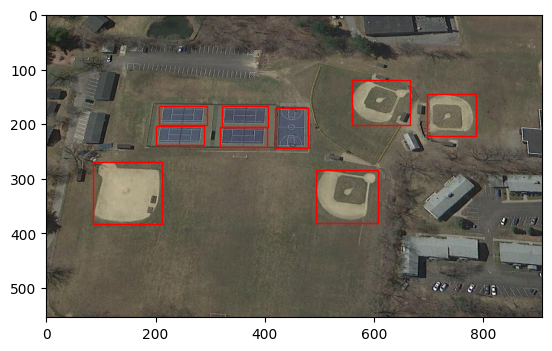

In [2]:

def load_image(image_path):
    """Load an image from a file path."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return image

def load_annotations(annotation_path):
    """Load annotations from a file path."""
    annotations = []
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        # Clean the line and check if it's not empty
        line = line.strip()
        if not line:
            continue  # Skip empty lines

        try:
            # Split by ',' to separate the coordinates and the class label
            parts = line.split(',')
            if len(parts) < 4:  # Ensuring there are enough parts for two coordinates
                print(f"Skipping line due to incorrect format: {line}")
                continue

            # Process coordinates by removing parentheses and splitting by comma
            coords = [int(coord) for coord in re.findall(r'\d+', line)]
            x1, y1, x2, y2 = coords[:4]
            class_label = int(parts[4])  # Assuming class label is the fifth element after splitting

            annotations.append(((x1, y1, x2, y2), class_label))
        except Exception as e:
            print(f"Error parsing line '{line}': {e}")
            continue

    return annotations

def show_image_with_boxes(image, annotations):
    """Display an image and its annotated bounding boxes."""
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for annotation in annotations:
        bbox, label = annotation
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none', label=str(label))
        ax.add_patch(rect)
    plt.show()

# Example usage for a single image and annotation file
image_dir = '/kaggle/input/positive'
annotations_dir = '/kaggle/input/ground'
image_filename = '631.jpg'

image = load_image(os.path.join(image_dir, image_filename))
annotations = load_annotations(os.path.join(annotations_dir, image_filename.replace('.jpg', '.txt')))
show_image_with_boxes(image, annotations)


In [3]:
# Initialize empty lists to store images and annotations
images = []
all_annotations = []

# Iterate over each image file in the directory
for image_filename in os.listdir(image_dir):
    # Load the image
    image_path = os.path.join(image_dir, image_filename)
    image = load_image(image_path)
    
    # Load annotations for the current image
    annotation_path = os.path.join(annotations_dir, image_filename.replace('.jpg', '.txt'))
    annotations = load_annotations(annotation_path)
    
    # Append the loaded image and its annotations to the lists
    images.append(image)
    all_annotations.append(annotations)



In [4]:
import os
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split

# Define the augmentation pipeline for the training data
train_transform = A.Compose([
    A.Resize(1024, 1024),  # Resize all images to 1024x1024
    A.HorizontalFlip(p=0.5),  # 50% chance to flip image horizontally
    A.VerticalFlip(p=0.5),   # 50% chance to flip image vertically
    A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_REPLICATE),  # Random rotation between -45 and 45 degrees
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet50
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def apply_augmentations(transform, image, annotations):
    """Apply the defined augmentations to the image and annotations."""
    class_labels = [annotation[1] for annotation in annotations]
    bboxes = [annotation[0] for annotation in annotations]
    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    return augmented['image'], augmented['bboxes'], augmented['class_labels']

# Assuming 'images' and 'all_annotations' are populated from earlier loading
train_images, test_images, train_annotations, test_annotations = train_test_split(
    images, all_annotations, test_size=0.2, random_state=42)

# Apply augmentations only to the training images
augmented_train_images = []
augmented_train_annotations = []

for image, annotations in zip(train_images, train_annotations):
    aug_image, aug_bboxes, aug_class_labels = apply_augmentations(train_transform, image, annotations)
    # Here, you should create a dictionary for each annotation
    augmented_annotation = {'boxes': aug_bboxes, 'labels': aug_class_labels}
    augmented_train_annotations.append(augmented_annotation)
    augmented_train_images.append(aug_image)

# Visualization function needs to be defined to show images with bounding boxes
# Example:
#show_image_with_boxes(augmented_train_images[0], augmented_train_annotations[0])
# show_image_with_boxes(test_images[0], test_annotations[0])


In [5]:
def check_image_sizes(images):
    """Check if all images are resized to 1024x1024."""
    correct_size = True
    for img in images:
        if img.shape[0] != 1024 or img.shape[1] != 1024:
            correct_size = False
            break
    return correct_size
check_image_sizes(test_images)
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1024, 1024))
    return image

def normalize_image(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    normalized_image = image / 255.0
    normalized_image = (normalized_image - mean) / std
    return normalized_image

def denormalize_image(normalized_image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    denormalized_image = normalized_image * std + mean
    denormalized_image = np.clip(denormalized_image, 0, 1)  # Ensure pixel values are valid
    denormalized_image = (denormalized_image * 255).astype(np.uint8)
    return denormalized_image

# Load and normalize the image
#image_path = 'path_to_your_image.jpg'
#image = load_and_preprocess_image(image_path)
#normalized_image = normalize_image(image)

# Denormalize for visualization
#denormalized_image = denormalize_image(normalized_image)

# Show the original and denormalized images
#plt.figure(figsize=(12, 6))
#plt.subplot(121)
#plt.title('Original Image')
#plt.imshow(image)
#plt.axis('off')

#plt.subplot(122)
#plt.title('Denormalized Image')
#plt.imshow(denormalized_image)
#plt.axis('off')

#plt.show()


In [6]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load a pre-trained model for classification and return
    # only the features
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # Replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = num_classes  # 1 class (object) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Adjust `num_classes` to the number of classes in your dataset
model = get_model_instance_segmentation(num_classes=10)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 157MB/s]  


In [7]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets

In [8]:
def log_losses(loss_dict):
    logs = {k: v.item() for k, v in loss_dict.items()}
    log_message = " ".join([f"{key}: {value:.4f}" for key, value in logs.items()])
    return log_message




In [9]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim.lr_scheduler import LambdaLR

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to evaluate model on validation dataset
def evaluate_model(model, val_data_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
            predictions = model(images)
            all_predictions.extend(predictions)
            all_targets.extend(targets)

    return all_predictions, all_targets


In [11]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def show_predictions(images, targets, predictions):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(images[0].permute(1, 2, 0).cpu().numpy())
    for box, label in zip(targets[0]['boxes'], targets[0]['labels']):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    
    for box, label, score in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [12]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, images, annotations, transform=None):
        self.images = images
        self.annotations = annotations
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        annotation = self.annotations[idx]
        if self.transform:
            transformed = self.transform(image=image, bboxes=annotation['boxes'], class_labels=annotation['labels'])
            image = transformed['image']
            annotation = {'boxes': transformed['bboxes'], 'labels': transformed['class_labels']}
        image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1)
        annotation['boxes'] = torch.as_tensor(annotation['boxes'], dtype=torch.float32)
        annotation['labels'] = torch.as_tensor(annotation['labels'], dtype=torch.int64)
        return image, annotation

    def __len__(self):
        return len(self.images)




In [13]:
def get_faster_rcnn_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [14]:
# Gradual learning rate warm-up
def lr_lambda(epoch):
    return 1 if epoch > 5 else 0.1 + 0.18 * epoch  # Gradually ramp up the learning rate

In [15]:
def log_losses(loss_dict):
    logs = {k: v.item() for k, v in loss_dict.items()}
    log_message = " ".join([f"{key}: {value:.4f}" for key, value in logs.items()])
    return log_message


In [16]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import LambdaLR


# Instantiate model and optimizer with weight decay
num_classes = 11  # Including background
model = get_faster_rcnn_model(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Lower initial learning rate and add weight decay

scheduler = LambdaLR(optimizer, lr_lambda)

# Data loading
train_dataset = CustomDataset(images=augmented_train_images, annotations=augmented_train_annotations)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 176MB/s] 


In [17]:
from torchvision.ops import box_iou

def calculate_tp_fn(predictions, targets, iou_threshold=0.5):
    true_positives = 0
    false_negatives = 0

    for prediction, target in zip(predictions, targets):
        pred_boxes = prediction['boxes']
        target_boxes = target['boxes']

        if pred_boxes.shape[0] == 0 and target_boxes.shape[0] == 0:
            continue  # No boxes to compare, move to next

        if pred_boxes.shape[0] == 0 and target_boxes.shape[0] != 0:
            false_negatives += target_boxes.shape[0]
            continue

        iou_matrix = box_iou(pred_boxes, target_boxes)

        # Determine matches based on IoU threshold
        match_found = iou_matrix > iou_threshold
        true_positives += match_found.any(0).sum().item()  # Sum over target boxes (columns)
        false_negatives += (~match_found.any(0)).sum().item()  # Count unmatched target boxes

    return true_positives, false_negatives


In [18]:
def compute_recall(pred, target):
    # Extract predicted and ground truth boxes
    pred_boxes = pred['boxes']
    target_boxes = target['boxes']
    
    # Compute intersection over union (IoU) between predicted and ground truth boxes
    ious = box_iou(pred_boxes, target_boxes)
    
    # Calculate true positives (TP) by counting the number of predicted boxes with IoU > threshold
    TP = (ious > 0.5).sum().item()
    
    # Calculate false negatives (FN) as the difference between total ground truth boxes and TP
    FN = len(target_boxes) - TP
    
    # Compute recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return recall

def compute_precision(pred, target):
    # Extract predicted and ground truth boxes
    pred_boxes = pred['boxes']
    target_boxes = target['boxes']
    
    # Compute intersection over union (IoU) between predicted and ground truth boxes
    ious = box_iou(pred_boxes, target_boxes)
    
    # Calculate true positives (TP) by counting the number of predicted boxes with IoU > threshold
    TP = (ious > 0.5).sum().item()
    
    # Calculate false positives (FP) as the difference between total predicted boxes and TP
    FP = len(pred_boxes) - TP
    
    # Compute precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    return precision


**Adam faster rcnn
**

Epoch 1, Average Loss: 0.8055039868331872, Recall: 0.7822997416020672
Epoch 2, Average Loss: 0.5627046495962601, Recall: 0.939922480620155
Epoch 3, Average Loss: 0.4293490514159203, Recall: 0.9696382428940569
Epoch 4, Average Loss: 0.386500301799522, Recall: 0.9799741602067183
Epoch 5, Average Loss: 0.3712665489086738, Recall: 0.9809431524547804
Epoch 6, Average Loss: 0.3436309120259606, Recall: 0.9912790697674418
Epoch 7, Average Loss: 0.30990864807883134, Recall: 0.9928940568475452
Epoch 8, Average Loss: 0.27677639545872806, Recall: 0.9861111111111112
Epoch 9, Average Loss: 0.2592132134721256, Recall: 0.9922480620155039
Epoch 10, Average Loss: 0.24840178817797165, Recall: 0.9919250645994832


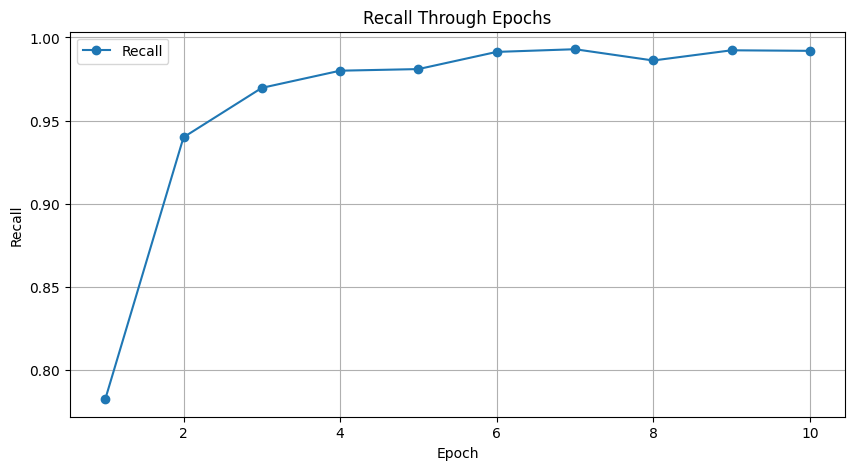

In [19]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model and optimizer with weight decay
num_classes = 10 + 1  # Including background
model = get_faster_rcnn_model(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Lower initial learning rate and add weight decay

scheduler = LambdaLR(optimizer, lr_lambda)

# Data loading
train_dataset = CustomDataset(images=augmented_train_images, annotations=augmented_train_annotations)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Training loop with gradient clipping
model.train()
num_epochs = 10
from torchvision.ops import box_iou

# Storage for epoch IoUs
epoch_iou_values_custom = []

# Storage for IoUs and recall values
epoch_recall_values_custom = []

for epoch in range(num_epochs):
    epoch_loss = 0
    batch_ious = []
    all_true_positives = 0
    all_false_negatives = 0

    for images, targets in train_data_loader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
 
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Calculate IoU and recall for predictions
        model.eval()  # Switch to evaluation mode for more stable predictions
        with torch.no_grad():
            predictions = model(images)
        model.train()  # Switch back to training mode

        tp, fn = calculate_tp_fn(predictions, targets)
        all_true_positives += tp
        all_false_negatives += fn

        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    # Store average IoU and recall for the epoch
    epoch_recall = all_true_positives / (all_true_positives + all_false_negatives) if (all_true_positives + all_false_negatives) > 0 else 0
    epoch_recall_values_custom.append(epoch_recall)

    epoch_loss /= len(train_data_loader)
    print(f'Epoch {epoch + 1}, Average Loss: {epoch_loss}, Recall: {epoch_recall}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), epoch_recall_values_custom, marker='o', label='Recall')
plt.title('Recall Through Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area

def evaluate_predictions(ground_truths, predictions, iou_threshold=0.5):
    """Evaluate predictions against ground truths using IoU threshold."""
    all_gts = []
    all_preds = []
    for gt_boxes, pred_boxes in zip(ground_truths, predictions):
        gt_labels = [box[1] for box in gt_boxes]
        if not pred_boxes:  # No predictions at all for this image
            pred_labels = [-1] * len(gt_labels)  # Use -1 or another placeholder for no detection
        else:
            pred_labels = []
            for gt_box in gt_boxes:
                match_found = False
                for pred_box in pred_boxes:
                    if calculate_iou(gt_box[0], pred_box[0]) > iou_threshold:
                        pred_labels.append(pred_box[1])
                        match_found = True
                        break
                if not match_found:
                    pred_labels.append(-1)  # No valid prediction found for this ground truth

        all_gts.extend(gt_labels)
        all_preds.extend(pred_labels)

    return all_gts, all_preds

# Assuming validation dataset exists as val_data_loader
model.eval()
all_ground_truths = []
all_predictions = []

for images, targets in train_data_loader:  # Ensure you have a validation loader named val_data_loader
    images = [img.to(device) for img in images]
    outputs = model(images)
    for target, output in zip(targets, outputs):
        gt_boxes = [(box.detach().cpu().numpy(), label.item()) for box, label in zip(target['boxes'], target['labels'])]
        pred_boxes = [(box.detach().cpu().numpy(), label.item()) for box, label in zip(output['boxes'], output['labels'])]
        all_ground_truths.append(gt_boxes)
        all_predictions.append(pred_boxes)

all_gts, all_preds = evaluate_predictions(all_ground_truths, all_predictions)
conf_matrix = confusion_matrix(all_gts, all_preds, labels=list(range(num_classes+1)))  # +1 to include placeholder -1 if used
print(conf_matrix)


[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 565   0   0   0   0   0   0   0   0   0   0]
 [  0   0 220   0   0   0   0   0   0   0   0   0]
 [  0   0   1 576   0   0   0   0   0   0   0   0]
 [  0   0   0   0 324   0   0   0   0   0   0   0]
 [  0   0   1   0   0 444   0   0   1   0   0   0]
 [  0   0   0   0   0   0 129   0   0   0   0   0]
 [  0   0   0   0   0   0   0 139   0   0   0   0]
 [  0   0   0   0   0   0   0   0 166   2   0   0]
 [  0   0   0   0   0   0   0   0   0 108   0   0]
 [  0   0   0   0   0   0   0   0   0   0 413   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


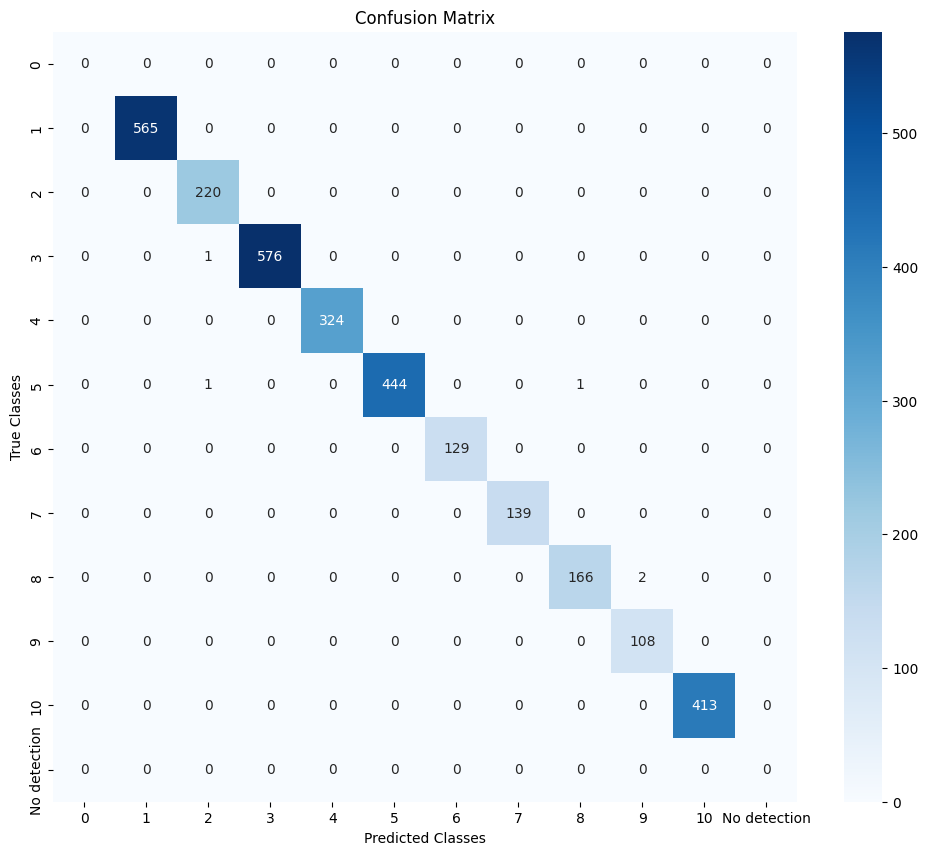

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'conf_matrix' is your confusion matrix array
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(num_classes)] + ['No detection'],
            yticklabels=[str(i) for i in range(num_classes)] + ['No detection'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [22]:
# Enregistrer le modèle à l'emplacement spécifié
#model_path = r'C:\Users\MSI\Downloads\Deep Learning\Deep Learning\Project\NWPU VHR-10 dataset\NWPU VHR-10 dataset\faster_rcnn_model.pth'
#torch.save(model.state_dict(), model_path)
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have a validation dataset and dataloader
#val_dataset = CustomDataset(images=augmented_val_images, annotations=augmented_val_annotations)
#val_data_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                preds = output['labels'].cpu().numpy()
                labels = targets[i]['labels'].cpu().numpy()
                
                all_preds.extend(preds)
                all_labels.extend(labels)
                
    return all_preds, all_labels



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Average Loss: 0.9475644058906115, Recall: 0.3775839793281654
Epoch 2, Average Loss: 0.83990038140462, Recall: 0.7228682170542635
Epoch 3, Average Loss: 0.7756170075100202, Recall: 0.83656330749354
Epoch 4, Average Loss: 0.6970765830805669, Recall: 0.8888888888888888
Epoch 5, Average Loss: 0.6329257424634237, Recall: 0.9131136950904393
Epoch 6, Average Loss: 0.579098723599544, Recall: 0.9337855297157622
Epoch 7, Average Loss: 0.5420268020950831, Recall: 0.9412144702842378
Epoch 8, Average Loss: 0.5102987125515938, Recall: 0.9541343669250646
Epoch 9, Average Loss: 0.48084348586316294, Recall: 0.9593023255813954
Epoch 10, Average Loss: 0.46358590077322265, Recall: 0.9631782945736435


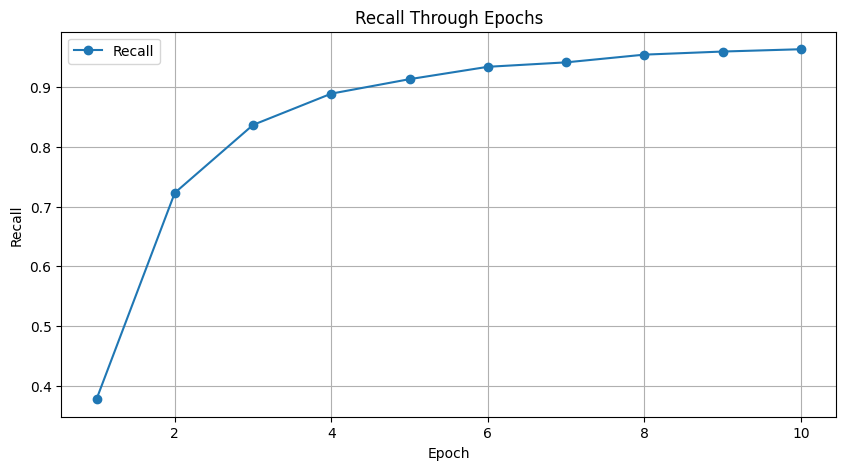

In [23]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
num_classes = 10 + 1  # Including background
model = get_faster_rcnn_model(num_classes).to(device)

# Define optimizer with weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)  # Use SGD with momentum

scheduler = LambdaLR(optimizer, lr_lambda)

# Data loading
train_dataset = CustomDataset(images=augmented_train_images, annotations=augmented_train_annotations)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Training loop with gradient clipping
model.train()
num_epochs = 10

# Storage for IoUs and recall values
epoch_recall_values = []

for epoch in range(num_epochs):
    epoch_loss = 0
    all_true_positives = 0
    all_false_negatives = 0

    for images, targets in train_data_loader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
 
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Calculate IoU and recall for predictions
        model.eval()  # Switch to evaluation mode for more stable predictions
        with torch.no_grad():
            predictions = model(images)
        model.train()  # Switch back to training mode

        tp, fn = calculate_tp_fn(predictions, targets)
        all_true_positives += tp
        all_false_negatives += fn

        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    # Store average IoU and recall for the epoch
    epoch_recall = all_true_positives / (all_true_positives + all_false_negatives) if (all_true_positives + all_false_negatives) > 0 else 0
    epoch_recall_values.append(epoch_recall)

    epoch_loss /= len(train_data_loader)
    print(f'Epoch {epoch + 1}, Average Loss: {epoch_loss}, Recall: {epoch_recall}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), epoch_recall_values, marker='o', label='Recall')
plt.title('Recall Through Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()


10
10


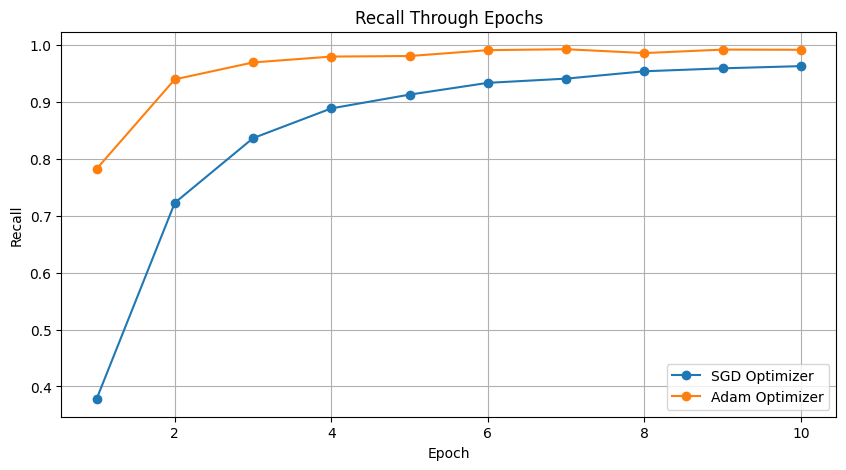

In [28]:
# Plotting
plt.figure(figsize=(10, 5))
num_epochs = 10  # Assuming this is your number of epochs
print(len(epoch_recall_values))  # Should output 10
print(len(epoch_recall_values_custom))  # Should output 10


# Plot SGD optimizer results
plt.plot(range(1, num_epochs+1), epoch_recall_values, marker='o', label='SGD Optimizer')

# Plot Adam optimizer results
plt.plot(range(1, num_epochs+1), epoch_recall_values_custom, marker='o', label='Adam Optimizer')

plt.title('Recall Through Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()

Epoch 1, Average Loss: 14.060074806213379, Recall: 0.09819121447028424
Epoch 2, Average Loss: 12.636476802825928, Recall: 0.1101421188630491
Epoch 3, Average Loss: 12.633273117358868, Recall: 0.14114987080103358
Epoch 4, Average Loss: 12.358673524856567, Recall: 0.13630490956072353
Epoch 5, Average Loss: 12.153281079805815, Recall: 0.1375968992248062
Epoch 6, Average Loss: 11.847737939541156, Recall: 0.1547157622739018
Epoch 7, Average Loss: 11.537618479361901, Recall: 0.17732558139534885
Epoch 8, Average Loss: 10.512840017905603, Recall: 0.19056847545219638
Epoch 9, Average Loss: 9.355635166168213, Recall: 0.21156330749354005
Epoch 10, Average Loss: 8.272926486455477, Recall: 0.2606589147286822
Epoch 11, Average Loss: 7.550498098593492, Recall: 0.2948966408268734
Epoch 12, Average Loss: 7.166549781652598, Recall: 0.4005167958656331
Epoch 13, Average Loss: 6.9160014390945435, Recall: 0.40406976744186046
Epoch 14, Average Loss: 6.651375980560596, Recall: 0.4896640826873385
Epoch 15, Ave

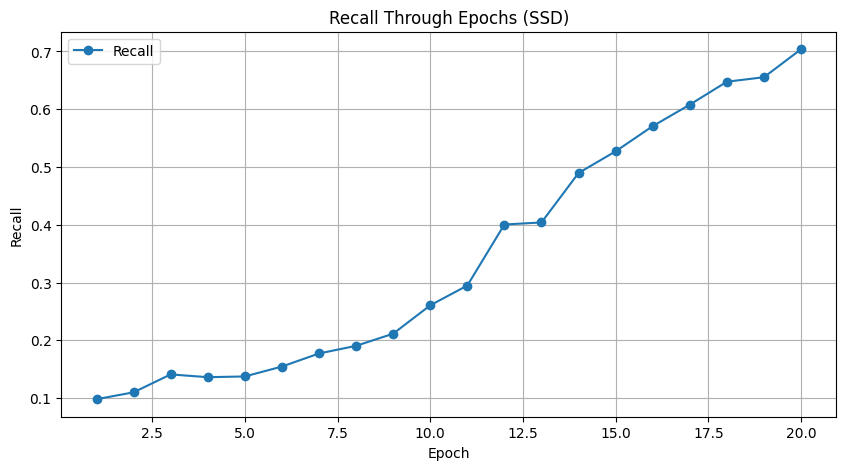

In [30]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

# Define SSD model
model = torchvision.models.detection.ssd300_vgg16(pretrained=False, num_classes=num_classes).to(device)

# Define optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = LambdaLR(optimizer, lr_lambda)

# Data loading
train_dataset = CustomDataset(images=augmented_train_images, annotations=augmented_train_annotations)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Training loop with recall calculation
model.train()
num_epochs = 20

epoch_loss_values = []
epoch_recall_values = []

for epoch in range(num_epochs):
    epoch_loss = 0
    all_true_positives = 0
    all_false_negatives = 0

    for images, targets in train_data_loader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Calculate recall for predictions
        model.eval()
        with torch.no_grad():
            predictions = model(images)
        model.train()

        tp, fn = calculate_tp_fn(predictions, targets)
        all_true_positives += tp
        all_false_negatives += fn

        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    epoch_loss /= len(train_data_loader)
    epoch_loss_values.append(epoch_loss)

    # Store average recall for the epoch
    epoch_recall = all_true_positives / (all_true_positives + all_false_negatives) if (all_true_positives + all_false_negatives) > 0 else 0
    epoch_recall_values.append(epoch_recall)

    print(f'Epoch {epoch + 1}, Average Loss: {epoch_loss}, Recall: {epoch_recall}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), epoch_recall_values, marker='o', label='Recall')
plt.title('Recall Through Epochs (SSD)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()


In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area

def evaluate_predictions(ground_truths, predictions, iou_threshold=0.5):
    """Evaluate predictions against ground truths using IoU threshold."""
    all_gts = []
    all_preds = []
    for gt_boxes, pred_boxes in zip(ground_truths, predictions):
        gt_labels = [box[1] for box in gt_boxes]
        if not pred_boxes:  # No predictions at all for this image
            pred_labels = [-1] * len(gt_labels)  # Use -1 or another placeholder for no detection
        else:
            pred_labels = []
            for gt_box in gt_boxes:
                match_found = False
                for pred_box in pred_boxes:
                    if calculate_iou(gt_box[0], pred_box[0]) > iou_threshold:
                        pred_labels.append(pred_box[1])
                        match_found = True
                        break
                if not match_found:
                    pred_labels.append(-1)  # No valid prediction found for this ground truth

        all_gts.extend(gt_labels)
        all_preds.extend(pred_labels)

    return all_gts, all_preds

# Assuming validation dataset exists as val_data_loader
model.eval()
all_ground_truths = []
all_predictions = []

for images, targets in train_data_loader:  # Assuming you have a validation loader named val_data_loader
    images = [img.to(device) for img in images]
    outputs = model(images)
    for target, output in zip(targets, outputs):
        gt_boxes = [(box.detach().cpu().numpy(), label.item()) for box, label in zip(target['boxes'], target['labels'])]
        pred_boxes = [(box.detach().cpu().numpy(), label.item()) for box, label in zip(output['boxes'], output['labels'])]
        all_ground_truths.append(gt_boxes)
        all_predictions.append(pred_boxes)

all_gts, all_preds = evaluate_predictions(all_ground_truths, all_predictions)
conf_matrix = confusion_matrix(all_gts, all_preds, labels=list(range(num_classes+1)))  # +1 to include placeholder -1 if used
print(conf_matrix)

[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0   0  36   1   0]
 [  0   0 131   0   5   1   0   0   0   5   7   0]
 [  0   0   0 279   0   0   0   0   0   0   3   0]
 [  0   0   0   0 261   3   0   4   0  26   0   0]
 [  0   0   0   0   0 317   0   0   0   7   0   0]
 [  0   0   0   0   0  44   0   3   0  23   0   0]
 [  0   0   0   0   0   0   0 129   0   1   0   0]
 [  0   0   0   0   0   0   0  10   2  40   0   0]
 [  0   0   0   0   0   1   0  36   0  42   0   0]
 [  0   0   0   0   0   0   0   0   0   0 265   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Average Loss: 12.054858064651489, Recall: 0.21511627906976744
Epoch 2, Average Loss: 6.1270505006496725, Recall: 0.599483204134367
Epoch 3, Average Loss: 5.351671376595131, Recall: 0.748062015503876
Epoch 4, Average Loss: 4.966242866332714, Recall: 0.7932816537467701
Epoch 5, Average Loss: 4.700991493005019, Recall: 0.8372093023255814
Epoch 6, Average Loss: 4.531365229533269, Recall: 0.8798449612403101
Epoch 7, Average Loss: 4.26928760271806, Recall: 0.898578811369509
Epoch 8, Average Loss: 4.112409282647646, Recall: 0.9160206718346253
Epoch 9, Average Loss: 3.8877797319338874, Recall: 0.9337855297157622
Epoch 10, Average Loss: 3.6221724377228663, Recall: 0.9467054263565892
Epoch 11, Average Loss: 3.2714431868149685, Recall: 0.96156330749354
Epoch 12, Average Loss: 3.177441850533852, Recall: 0.9609173126614987
Epoch 13, Average Loss: 2.8581836136487815, Recall: 0.975452196382429
Epoch 14, Average Loss: 2.6068623286027175, Recall: 0.9796511627906976
Epoch 15, Average Loss: 2.57

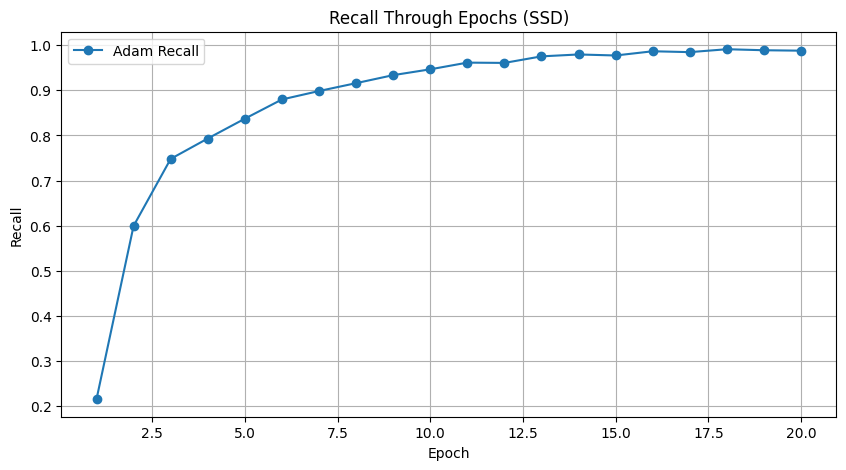

In [32]:
import torch
import torchvision
from torch.utils.data import DataLoader

# Define SSD model
model = torchvision.models.detection.ssd300_vgg16(pretrained=False, num_classes=num_classes).to(device)

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = LambdaLR(optimizer, lr_lambda)

# Data loading
train_dataset = CustomDataset(images=augmented_train_images, annotations=augmented_train_annotations)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Training loop with recall calculation
model.train()
num_epochs = 20

epoch_loss_values_adam = []
epoch_recall_values_adam = []

for epoch in range(num_epochs):
    epoch_loss = 0
    all_true_positives = 0
    all_false_negatives = 0

    for images, targets in train_data_loader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Calculate recall for predictions
        model.eval()
        with torch.no_grad():
            predictions = model(images)
        model.train()

        tp, fn = calculate_tp_fn(predictions, targets)
        all_true_positives += tp
        all_false_negatives += fn

        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    epoch_loss /= len(train_data_loader)
    epoch_loss_values_adam.append(epoch_loss)

    # Store average recall for the epoch
    epoch_recall_adam = all_true_positives / (all_true_positives + all_false_negatives) if (all_true_positives + all_false_negatives) > 0 else 0
    epoch_recall_values_adam.append(epoch_recall_adam)

    print(f'Epoch {epoch + 1}, Average Loss: {epoch_loss}, Recall: {epoch_recall_adam}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), epoch_recall_values_adam, marker='o', label='Adam Recall')
plt.title('Recall Through Epochs (SSD)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()


In [1]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 5))
num_epochs = 10  # Assuming this is your number of epochs
print(len(epoch_recall_values))  # Should output 20

print(len(epoch_recall_values_adam))  # Should output 20

# Plot SGD optimizer results for first 10 epochs
plt.plot(range(1, num_epochs+1), epoch_recall_values[:num_epochs], marker='o', label='SGD Optimizer')

# Plot Adam optimizer results for first 10 epochs
plt.plot(range(1, num_epochs+1), epoch_recall_values_adam[:num_epochs], marker='o', label='Adam Optimizer')

plt.title('Recall Through Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'epoch_recall_values' is not defined

<Figure size 2000x500 with 0 Axes>